In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

import torch
import torch.nn as nn

import torch.optim as optim

import sys
sys.path.insert(0, '../libraries/')

import cifar_data_utils
from cifar_vae_lib import CIFARConditionalVAE
from cifar_classifier_lib import Wide_ResNet
import cifar_semisupervised_lib

import semisupervised_vae_lib as ss_vae_lib

import pickle

# Load data

In [2]:
seed = 4254

In [3]:
batch_size = 50

In [4]:
cifar100 = False
if cifar100: 
    n_classes = 100
    data_dir = '../cifar100_data/'
else: 
    data_dir = '../cifar10_data/'
    n_classes = 10

np.random.seed(seed)
_ = torch.manual_seed(seed)

# LOAD DATA
train_set_labeled, train_set_unlabeled, test_set = \
    cifar_data_utils.load_semisupervised_cifar_dataset(cifar100=False, 
                                                       data_dir = data_dir, 
                                                       propn_sample = 1.0, propn_labeled = 1.0)
    
train_loader_labeled = torch.utils.data.DataLoader(
                 dataset=train_set_labeled,
                 batch_size=batch_size,
                 shuffle=True)

train_loader_unlabeled = torch.utils.data.DataLoader(
                 dataset=train_set_unlabeled,
                 batch_size=batch_size,
                 shuffle=True)

test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)

| Preparing CIFAR dataset...
Files already downloaded and verified
| Preparing CIFAR dataset...
Files already downloaded and verified


In [5]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict


In [6]:
seed = 435

np.random.seed(seed)
_ = torch.manual_seed(seed)

for batch_idx, d in enumerate(train_loader_labeled):
    data_labeled = d
    break

# for batch_idx, d in enumerate(train_loader_unlabeled):
#     data_unlabeled = d
#     break
    
for batch_idx, d in enumerate(test_loader):
    test_data = d
    break

In [7]:
with open('../cifar10_data/test_batch_cifar10.pkl', 'rb') as f:
    data_labeld_r = pickle.load(f)

In [8]:
def plot_cifar_image(image, fig, label = None, scale = True):
    if scale: 
        image_unscaled = image * cifar_data_utils.CIFAR10_STD_TENSOR + cifar_data_utils.CIFAR10_MEAN_TENSOR
    else: 
        image_unscaled = image

    img = np.dstack((image_unscaled[0, :, :],
                            image_unscaled[1, :, :],
                            image_unscaled[2, :, :]))
    
    print(np.min(img))
    
    fig.imshow(img)
    
    if label is not None: 
        fig.set_title(cifar_data_utils.cifar100_fine_labels_legend[label])
        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-2.9802322e-08
-2.9802322e-08
-2.9802322e-08
-2.9802322e-08
-2.9802322e-08


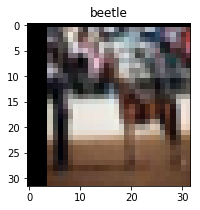

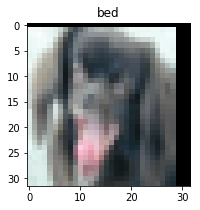

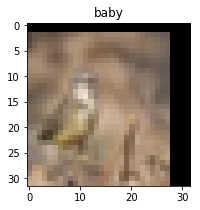

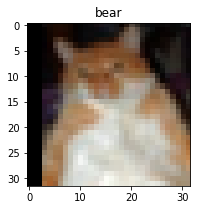

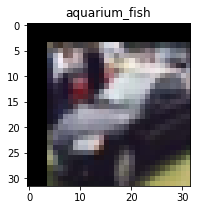

In [9]:
for n in range(5): 
    _, axarr = plt.subplots(1, 1, figsize=(3, 3))

    plot_cifar_image(data_labeled['image'][n, :, :], axarr, data_labeled['label'][n], scale = True)

In [10]:
slen = data_labeled['image'].shape[-1]

# Define VAE

In [11]:
image_config = {'use_cifar100': False, 'slen': 32,
                 'channel_num': 3,
                 'n_classes': n_classes}

cond_vae_config = {'kernel_num': 128,
                   'z_size': 128}

classifier_config = {'depth': 100,
                     'k': 12}

In [12]:
vae = cifar_semisupervised_lib.get_cifar_semisuperivsed_vae(image_config,
                                                            cond_vae_config,
                                                            classifier_config)


In [13]:
# Load results

file_base = '../cifar_vae_results/testing_vae_cifar10_alllabeled'

which_epoch = 'final'

# enc_file = file_base + '_enc_' + which_epoch
# dec_file = file_base + '_dec_' + which_epoch
vae_file = file_base + '_cond_vae_' + which_epoch
classifier_file = file_base + '_classifier_' + which_epoch

# enc_file = "../mnist_vae_results_aws/mnist_vae_semisuper_reinforce_simple_baseline_enc_final"
# dec_file = '../mnist_vae_results_aws/mnist_vae_semisuper_reinforce_simple_baseline_dec_final'
# classifier_file = '../mnist_vae_results_aws/mnist_vae_semisuper_reinforce_simple_baseline_classifier_final'


# vae.conditional_vae.encoder.load_state_dict(torch.load(enc_file,
#                                map_location=lambda storage, loc: storage))

# vae.conditional_vae.decoder.load_state_dict(torch.load(dec_file,
#                                map_location=lambda storage, loc: storage))

vae.conditional_vae.load_state_dict(torch.load('../cifar_vae_results/cifar_vae',
                               map_location=lambda storage, loc: storage))

# vae.conditional_vae.load_state_dict(torch.load(vae_file,
#                                map_location=lambda storage, loc: storage))


vae.classifier.load_state_dict(torch.load(classifier_file,
                               map_location=lambda storage, loc: storage))


vae.eval()

SemiSupervisedVAE(
  (conditional_vae): CIFARConditionalVAE(
    (encoder): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (1): Sequential(
        (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (2): Sequential(
        (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (cond_encoder): Sequential(
      (0): Sequential(
        (0): Linear(in_features=2058, out_features=128, bias=True)
        (1): ReLU()
      )
      (1): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=Tru

In [14]:
image_mu, z_ind = ss_vae_lib.get_reconstructions(vae, data_labeld_r['image'], 
                                                 labels = data_labeld_r['label'])
print('debug recon means', np.unique(image_mu.cpu().detach().numpy().flatten()))

debug recon means [0.5        0.5000095  0.5000146  ... 0.99999976 0.9999999  1.        ]


In [15]:
x, label = data_labeled['image'], data_labeled['label']

In [16]:
encoded = vae.conditional_vae.encoder(x)

latent_means, latent_log_var, one_hot_labels = \
            vae.conditional_vae.cond_encoder_forward(encoded, label)

latent_std = torch.exp(0.5 * latent_log_var)

# Check losses

In [17]:
loss_array = np.loadtxt(file_base + '_loss_array.txt')

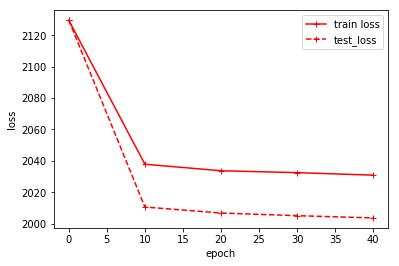

In [18]:
# plot losses
start_indx = 0

plt.plot(loss_array[0, start_indx:], loss_array[1, start_indx:], 'r-+')
plt.plot(loss_array[0, start_indx:], loss_array[2, start_indx:], 'r--+')

plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(('train loss', 'test_loss'))

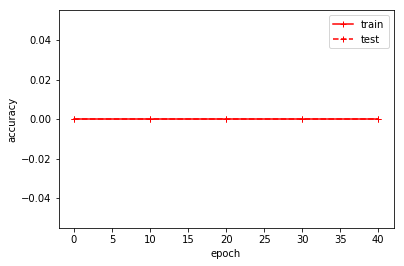

In [19]:
# plot trianing accuracy
plt.plot(loss_array[0, start_indx:], loss_array[3, start_indx:], 'r-+')
plt.plot(loss_array[0, start_indx:], loss_array[4, start_indx:], 'r--+')

plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(('train', 'test'))

# Check reconstructions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-2.9802322e-08
0.5
-2.9802322e-08
0.5
-2.9802322e-08
0.5
-2.9802322e-08
0.5
-2.9802322e-08
0.5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-2.9802322e-08
0.5
-2.9802322e-08
0.5
-2.9802322e-08
0.5
-2.9802322e-08
0.5


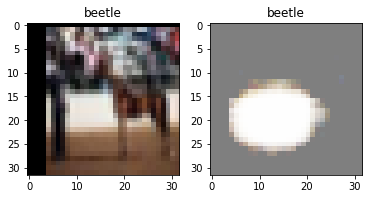

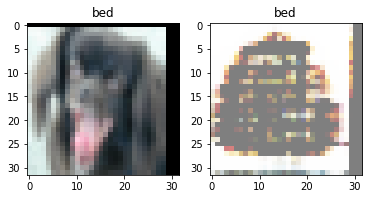

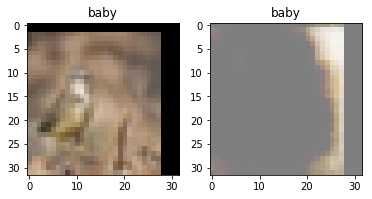

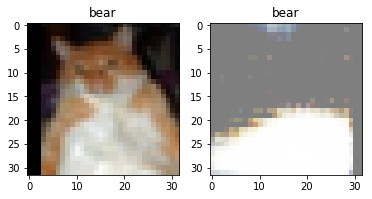

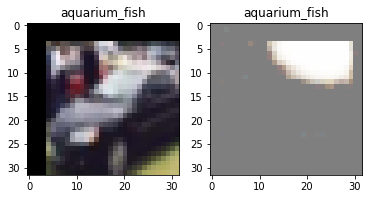

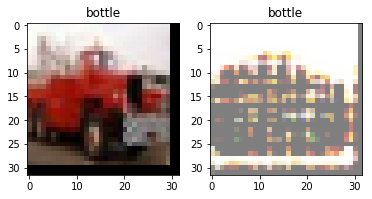

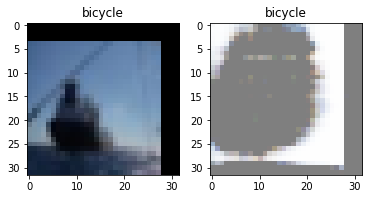

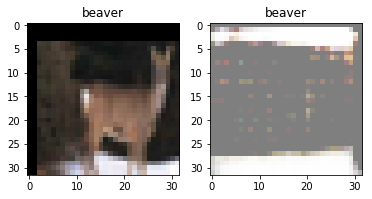

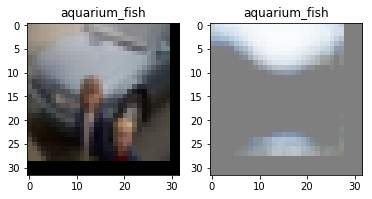

In [20]:
# Look at training images
use_true_labels = True
if use_true_labels: 
    labels=data_labeled['label']
else: 
    labels = None 

image_mu, z_ind = ss_vae_lib.get_reconstructions(vae, data_labeled['image'], labels = labels)

figsize = 8
for i in range(0, 9): 
    
    _, axarr = plt.subplots(1, 2, figsize=(6, 6))
    
    plot_cifar_image(data_labeled['image'].detach()[i, :, :, :], axarr[0], labels[i], scale = True)
    plot_cifar_image(image_mu.detach()[i, :, :, :], axarr[1], labels[i], scale = False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-2.9802322e-08
0.5
-2.9802322e-08
0.5
-2.9802322e-08
0.5
-2.9802322e-08
0.5
-2.9802322e-08
0.5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-2.9802322e-08
0.5
-2.9802322e-08
0.5
-2.9802322e-08
0.5
-2.9802322e-08
0.5
-2.9802322e-08
0.5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-2.9802322e-08
0.5
-2.9802322e-08
0.5
-2.9802322e-08
0.5
-2.9802322e-08
0.5
-2.9802322e-08
0.5
-2.9802322e-08


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/home/runjing_liu/anaconda3/envs/pytorch_update/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


0.5
-2.9802322e-08
0.5
-2.9802322e-08
0.5
-2.9802322e-08
0.5
-2.9802322e-08
0.5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-2.9802322e-08
0.5
-2.9802322e-08
0.5
-2.9802322e-08
0.5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-2.9802322e-08
0.5
-2.9802322e-08
0.5
-2.9802322e-08
0.5
-2.9802322e-08
0.5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-2.9802322e-08
0.5
-2.9802322e-08
0.5
-2.9802322e-08
0.5


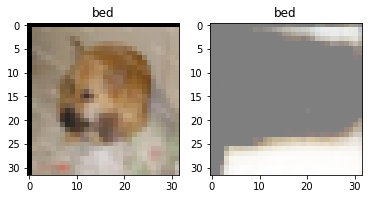

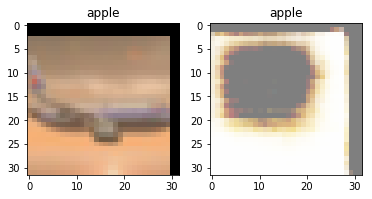

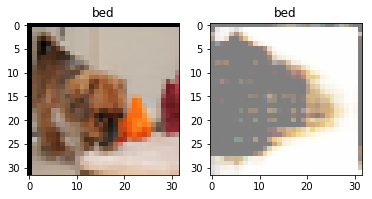

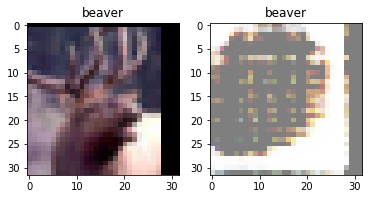

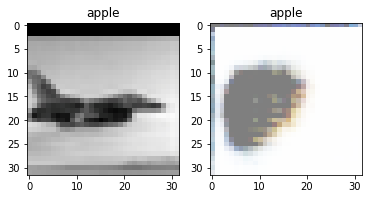

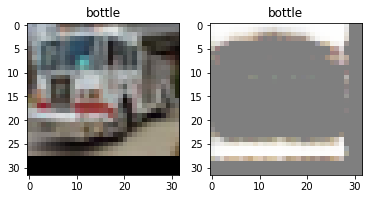

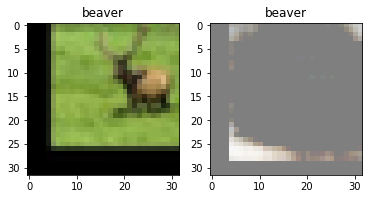

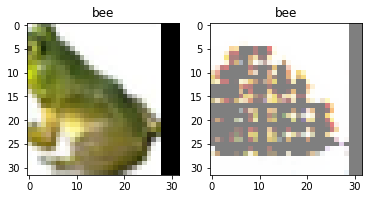

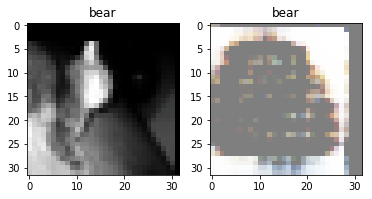

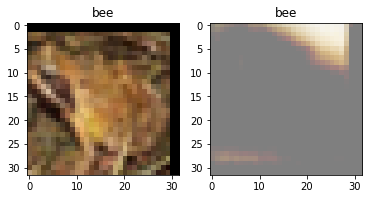

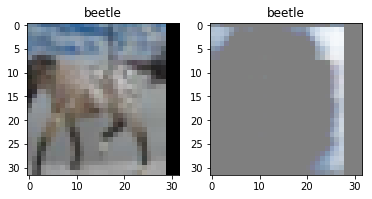

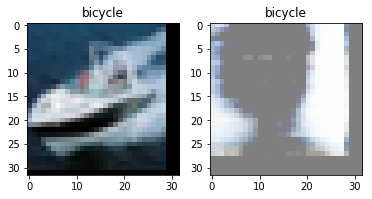

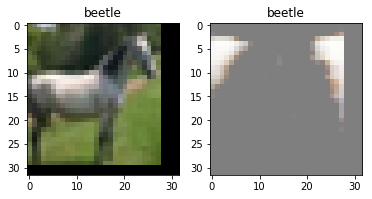

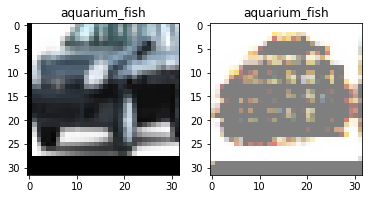

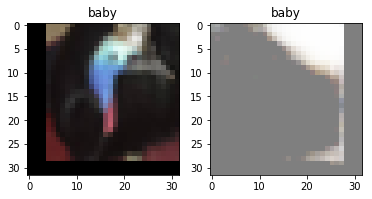

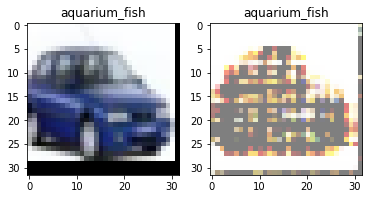

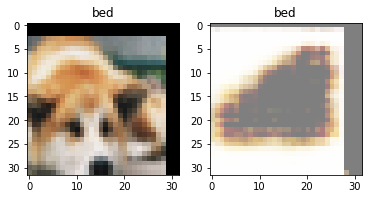

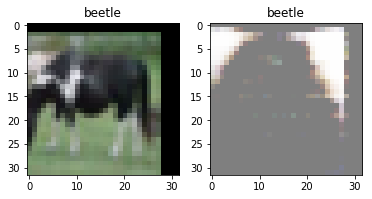

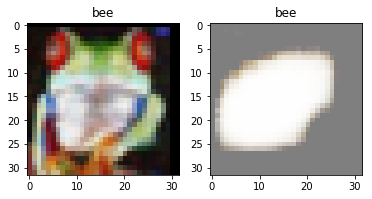

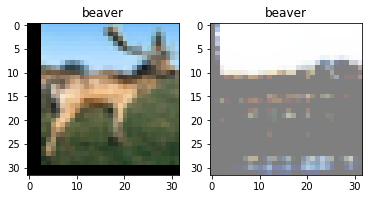

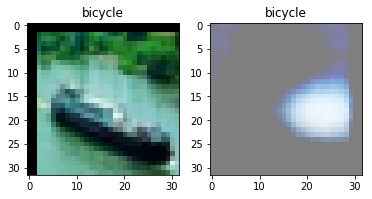

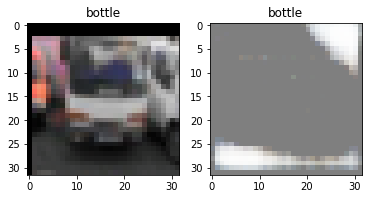

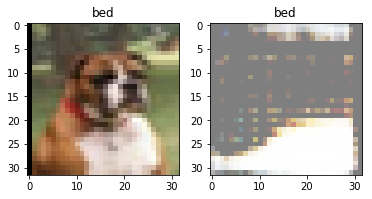

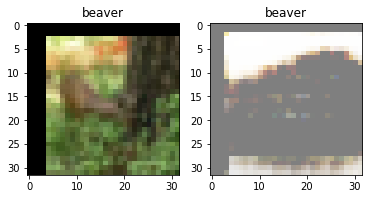

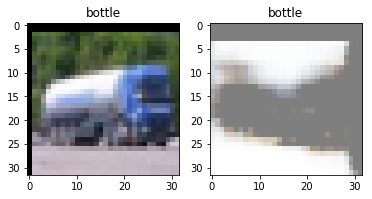

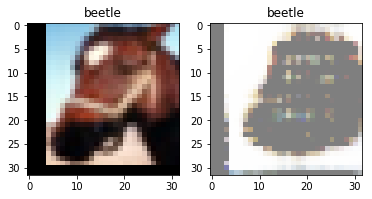

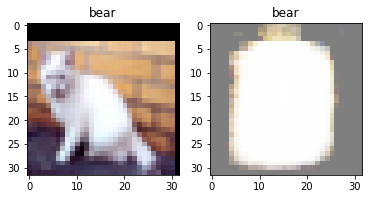

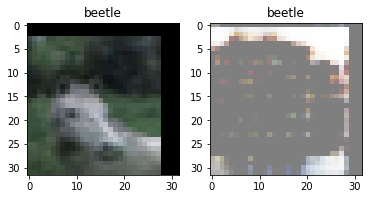

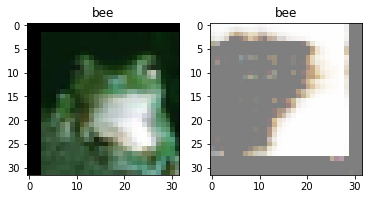

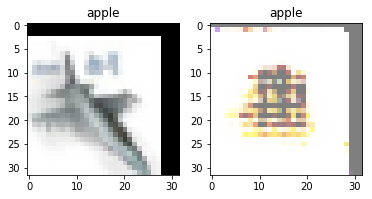

In [21]:
# Look at training images
use_true_labels = True
if use_true_labels: 
    labels=data_labeld_r['label']
else: 
    labels = None 

image_mu, z_ind = ss_vae_lib.get_reconstructions(vae, data_labeld_r['image'], labels = labels)

figsize = 8
for i in range(0, 30): 
    
    _, axarr = plt.subplots(1, 2, figsize=(6, 6))
    
    plot_cifar_image(data_labeld_r['image'].detach()[i, :, :, :], axarr[0], labels[i], scale = True)
    plot_cifar_image(image_mu.detach()[i, :, :, :], axarr[1], labels[i], scale = False)

In [25]:
cifar_semisupervised_lib.cifar_loglik(data_labeld_r['image'], image_mu, None, use_cifar100=False).mean()

tensor(-3926.8513)

In [23]:
torch.max(image_mu)

tensor(1.)

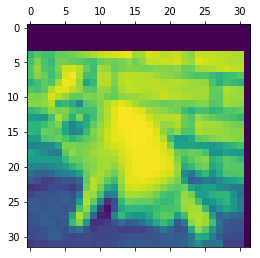

In [24]:
plt.matshow(data_labeld_r['image'][26, 0, :, :])

In [35]:
image_mu[26, 1, :, :]

tensor([[ 0.5000,  0.5000,  0.5000,  ...,  0.5000,  0.5000,  0.5000],
        [ 0.5000,  0.5000,  0.5000,  ...,  0.5000,  0.5000,  0.5000],
        [ 0.5000,  0.5000,  0.5000,  ...,  0.5000,  0.5000,  0.5000],
        ...,
        [ 0.5000,  0.5000,  0.5000,  ...,  0.5000,  0.5000,  0.5000],
        [ 0.5000,  0.5000,  0.5000,  ...,  0.5000,  0.5000,  0.5000],
        [ 0.5000,  0.5000,  0.5000,  ...,  0.5000,  0.5000,  0.5000]])

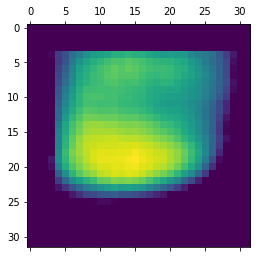

In [34]:
plt.matshow(image_mu[26, 1, :, :].detach())

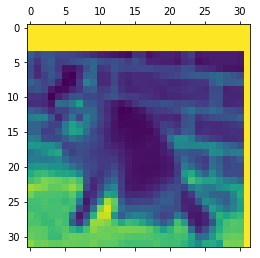

In [29]:
plt.matshow(image_mu[26, 0, :, :].detach() - data_labeld_r['image'][26, 0, :, :])